# 1 - Seq2Seq with Neural Networks for Household Load Data

## Imports

In [1]:
import os, sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning import LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import WandbLogger
from PIL import Image
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from io import BytesIO

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
#import plotly.express as px

import wandb
wandb.login()




Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nikolaushouben (wattcast). Use `wandb login --relogin` to force relogin


True

In [21]:
class ElectricalLoadDataset(Dataset):
    def __init__(self, data_dir, 
                input_chunk_size,
                output_chunk_size, 
                scaler = None,
                timeenc=False,
                split='train', 
                train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, SFH = -1):
        
        
        self.input_chunk_size = input_chunk_size
        self.output_chunk_size = output_chunk_size
        self.scaler = scaler
        self.timeenc = timeenc
        self.SFH = SFH

        load_series = self._load_data(data_dir)

        if self.scaler is None and split == 'train':
            self.scaler = MinMaxScaler()
            self.scaler.fit(load_series[:int(train_ratio * len(load_series))])

        if split == 'train':
            self.load_series = self.scaler.transform(load_series[:int(train_ratio * len(load_series))])
        elif split == 'val':
            self.load_series = self.scaler.transform(load_series[int(train_ratio * len(load_series)):int((train_ratio + val_ratio) * len(load_series))])
        elif split == 'test':
            self.load_series = self.scaler.transform(load_series[int((train_ratio + val_ratio) * len(load_series)):])


    def __len__(self):
        return len(self.load_series) - self.input_chunk_size - self.output_chunk_size + 1

    def __getitem__(self, idx):
        input_chunk = self.load_series[idx:idx+self.input_chunk_size]
        output_chunk = self.load_series[idx+self.input_chunk_size:idx+self.input_chunk_size+self.output_chunk_size]
        return input_chunk, output_chunk

    def _load_data(self, data_dir):
        df = pd.read_csv(os.path.join(data_dir, 'load_data_15min_watts.csv'), index_col=0, parse_dates=True)[:5000]
        df = df.iloc[:, [self.SFH]]
        if self.timeenc:
            df = self.timeenc_1(df)

        return df.values
            
    def timeenc_1(self, df):
        # minute of the day
        df['minute'] = df.index.hour * 60 + df.index.minute
        # day of the week
        df['dayofweek'] = df.index.dayofweek
        # day of the year
        df['dayofyear'] = df.index.dayofyear
        return df
    
    def timeenc_2(self, df):
        #trigonometric encoding
        df['minute_sin'] = np.sin(2 * np.pi * df.index.minute / 60)
        df['minute_cos'] = np.cos(2 * np.pi * df.index.minute / 60)
        df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
        df['dayofweek_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
        df['dayofweek_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)
        df['dayofyear_sin'] = np.sin(2 * np.pi * df.index.dayofyear / 365)
        df['dayofyear_cos'] = np.cos(2 * np.pi * df.index.dayofyear / 365)
        return df
    
class ElectricalLoadDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super(ElectricalLoadDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = self.collate_fn_

    def collate_fn_(self, batch):
        input_chunks, output_chunks = zip(*batch)
        input_tensor = torch.FloatTensor(input_chunks)
        output_tensor = torch.FloatTensor(output_chunks)
        return input_tensor, output_tensor
    

In [22]:
train = ElectricalLoadDataset(data_dir='../data', input_chunk_size=96, output_chunk_size=96, split='train', train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, timeenc=True)
train_loader = ElectricalLoadDataLoader(train, batch_size=16, shuffle=True)
val = ElectricalLoadDataset(data_dir='../data', scaler = train.scaler, input_chunk_size=96, output_chunk_size=96, split='val', train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, timeenc=True)
val_loader = ElectricalLoadDataLoader(val, batch_size=16, shuffle=True)
test = ElectricalLoadDataset(data_dir='../data', scaler = train.scaler, input_chunk_size=96, output_chunk_size=96, split='test', train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, timeenc=True)
test_loader = ElectricalLoadDataLoader(test, batch_size=16, shuffle=False)

## The classic Seq2Seq model with a GRU encoder and decoder 

(Sutskever et al. 2014)
https://arxiv.org/abs/1409.3215

In [26]:
class Encoder(LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        out, hidden = self.gru(x, h0)
        return out, hidden
    

class Decoder(LightningModule):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)


    def forward(self, x, hidden):
        out, hidden = self.gru(x, hidden)
        out = self.fc(out)
        return out, hidden

class Seq2Seq(LightningModule):
    
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        N, _, _ = src.shape
        N, output_chunk_size , output_size = trg.shape
        outputs = torch.zeros(N, output_chunk_size, output_size).to(self.device)
        out, hidden = self.encoder(src)
        inp = src[:,-1,:].unsqueeze(1)
        

        for t in range(0, output_chunk_size):
            output, hidden = self.decoder(inp, hidden)
            outputs[:,t,:] = output.squeeze(1)
            teacher_force = np.random.random() < teacher_forcing_ratio
            if self.training:
                inp = trg[:,t,:].unsqueeze(1) if teacher_force else output
            else:
                inp = output
        return outputs

    def training_step(self, batch):
        src, trg = batch
        output = self(src, trg)
        loss = F.mse_loss(output, trg)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        src, trg = batch
        output = self(src, trg)
        loss = F.mse_loss(output, trg)
        self.log('val_loss', loss)
        if batch_idx == 0:
            buffers = self._plot_predictions(output, trg)
            # Combine the image buffers into a single image
            images = [np.array(Image.open(buffer)) for buffer in buffers]
            combined_image = np.concatenate(images, axis=1)
            # Log the combined image to WandB
            wandb.log({"predictions_val_dataset": wandb.Image(combined_image)})
        return loss
    
    def test_step(self, batch, batch_idx):
        src, trg = batch
        output = self(src, trg)
        loss = F.mse_loss(output, trg)
        self.log('test_loss', loss)
        if batch_idx == 0:
            buffers = self._plot_predictions(output, trg)
            # Combine the image buffers into a single image
            images = [np.array(Image.open(buffer)) for buffer in buffers]
            combined_image = np.concatenate(images, axis=1)
            # Log the combined image to WandB
            wandb.log({"predictions_test_dataset": wandb.Image(combined_image)})
        return loss
        
    def _plot_predictions(self, preds, actuals):
        preds = preds.detach().cpu().numpy()
        actuals = actuals.detach().cpu().numpy()
        buffers = []
        for i in range(preds.shape[0]):
            fig, ax = plt.subplots(1, 1, figsize=(20, 10))
            # plotting the i-th sequence in the batch
            ax.plot(preds[i, :, 0], label='Predictions')
            ax.plot(actuals[i, :, 0], label='Actuals')
            ax.legend()
            # Convert the figure to an image buffer
            canvas = FigureCanvas(fig)
            buffer = BytesIO()
            canvas.print_figure(buffer, format='png')
            buffer.seek(0)
            # Close the figure to save memory
            plt.close(fig)
            # Append the image buffer to the list of buffers
            buffers.append(buffer)
        # Return the list of image buffers
        return buffers

    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)
    

In [27]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
enc = Encoder(input_size=4 , hidden_size=64, num_layers=1, dropout=0.2)
dec = Decoder(input_size=4, hidden_size=64, num_layers=1)
model = Seq2Seq(enc, dec)
wandb_logger = WandbLogger(project = 'SFH Load Forecasting', name = "GRU_classic_with_timeenc_no_teacher_forcing")


c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\pytorch_lightning\loggers\wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [28]:
cbs = [EarlyStopping(monitor='val_loss')]
trainer = pl.Trainer(max_epochs=10, logger = wandb_logger, gpus=1 if torch.cuda.is_available() else 0, callbacks=cbs)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)


c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:613: UserWarning: Checkpoint directory .\SFH Load Forecasting\n0ehcykm\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 13.4 K
1 | decoder | Decoder | 13.7 K
------------------------------------
27.1 K    Trainable params
0         Non-tr

Sanity Checking: 0it [00:00, ?it/s]

c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the nu

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [29]:
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.04881473258137703
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.04881473258137703}]

## One-shot Seq2Seq

In [7]:
# The idea here is that the decoder will be able to predict all outputs in one-shot instead of predicting one output at a time. 
# This is done by passing the entire input sequence to the encoder and then passing the last output of the encoder to the decoder. The decoder will then predict all outputs in one-shot.

class Seq2Seq_OS(LightningModule):
    
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg):
        N, _, _ = src.shape
        N, output_chunk_size , output_size = trg.shape
        outputs = torch.zeros(N, output_chunk_size, output_size).to(self.device)
        out, hidden = self.encoder(src)
        inp = src[:,-1,:].unsqueeze(1)
        
        # Use the decoder to predict all outputs in one-shot
        output, hidden = self.decoder(inp.repeat(1, output_chunk_size, 1), hidden)
        outputs = self.decoder.fc(output)
        return outputs

    def training_step(self, batch):
        src, trg = batch
        output = self(src, trg)
        loss = F.mse_loss(output, trg)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        src, trg = batch
        output = self(src, trg)
        loss = F.mse_loss(output, trg)
        self.log('val_loss', loss)
        if batch_idx == 0:
            buffer = self._plot_predictions(output, trg)
            img = np.array(Image.open(buffer))
            # Log the image to WandB
            wandb.log({"plot": wandb.Image(img)})
        return loss
    
    def test_step(self, batch, batch_idx):
        src, trg = batch
        output = self(src, trg)
        loss = F.mse_loss(output, trg)
        self.log('test_loss', loss)
        if batch_idx % 1 == 0:
            buffer = self._plot_predictions(output, trg, show = True)

        return loss
        
    def _plot_predictions(self, preds, actuals, show = False):
        preds = preds.detach().cpu().numpy()
        actuals = actuals.detach().cpu().numpy()
        fig, ax = plt.subplots(1, 1, figsize=(20, 10))
        ax.plot(preds[0, :, 0], label='Predictions')
        ax.plot(actuals[0, :, 0], label='Actuals')
        ax.legend()
        # Convert the figure to an image buffer
        canvas = FigureCanvas(fig)
        buffer = BytesIO()
        canvas.print_figure(buffer, format='png')
        buffer.seek(0)
        if show:
            fig.savefig(f'../figures/prediction_{self.current_epoch}.png')
        # Close the figure to save memory
        plt.close(fig)
        # Return the image buffer
        return buffer
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)
    

In [39]:
enc = Encoder(input_size=1, hidden_size=64, num_layers=1, dropout=0.2)
dec = Decoder(input_size=1, hidden_size=64, num_layers=1)
model = Seq2Seq_OS(enc, dec)
wandb_logger = WandbLogger(project = 'SFH Load Forecasting', name = 'one_shot')
trainer = pl.Trainer(max_epochs=10, logger = wandb_logger, gpus=1 if torch.cuda.is_available() else 0)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)


/Users/nikolaushouben/opt/anaconda3/envs/LearningBerkeley/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
/Users/nikolaushouben/opt/anaconda3/envs/LearningBerkeley/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/nikolaushouben/opt/anaconda3/envs/LearningBerkeley/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoi

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/nikolaushouben/opt/anaconda3/envs/LearningBerkeley/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


RuntimeError: mat1 and mat2 shapes cannot be multiplied (864x1 and 64x1)

## Encoder-Decoder with Attention

From the paper 'Learning to Align and Translate':

https://arxiv.org/abs/1409.0473

In [ ]:
class EncoderBad(nn.Module):

    def __init__(self,input_size, hidden_size):
        super(EncoderBad, self).__init__()  
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first = True, bidirectional = True)
        self.fc = nn.Linear(hidden_size * 2, hidden_size)

    def forward(self, input):    
        outputs, hidden = self.gru(input)  


        print(outputs.shape, hidden.shape)

        hidden_con = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        hidden = torch.tanh(self.fc(hidden_con))

        print(hidden.shape)
        return outputs, hidden

class Attention(nn.Module):
  def __init__(self, hidden_size):
    super(Attention, self).__init__()

    self.attn = nn.Linear(hidden_size * 3, hidden_size)
    self.v = nn.Linear(hidden_size, 1, bias = False)

  def forward(self, hidden, encoder_outputs):


    batch_size = encoder_outputs.shape[0]
    src_len = encoder_outputs.shape[1]

    hidden = hidden.unsqueeze(1).repeat(1, src_len, 1) #we open up the hidden tensor at index 1, and repeat it src length time at this index

    energy_input = torch.cat((hidden, encoder_outputs), dim = 2)

    energy = torch.tanh(self.attn(energy_input))
    attention = self.v(energy)

    return F.softmax(attention, dim = 1).squeeze(-1)



In [ ]:
src, trg = iter(trainloader).next()

src = torch.tensor(src, dtype=torch.float32).to(device)
trg = torch.tensor(trg, dtype=torch.float32).to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [ ]:
src.shape

torch.Size([8, 48, 1])

In [ ]:
encoder = EncoderBad(1,3)

outputs, hidden = encoder(src)


torch.Size([8, 48, 6]) torch.Size([2, 8, 3])
torch.Size([8, 3])


In [ ]:
print(hidden.shape, outputs.shape)

torch.Size([8, 3]) torch.Size([8, 48, 6])


In [ ]:
attn = Attention(3)

In [ ]:
class DecoderBad(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, attention):
      super(DecoderBad, self).__init__()   
      
      self.output_size = output_size
      self.attention = attention
      
      self.hidden_size = hidden_size
      self.gru = nn.GRU(input_size=hidden_size * 2 + input_size,  hidden_size=hidden_size, batch_first = True)
      self.fc_out = nn.Linear(hidden_size*3 + input_size, output_size)
  
    def forward(self, input, hidden, encoder_outputs):


      # encoder_outputs = [batch_size, src_len, hidden_size * 2]
      # hidden = [batch_size, hidden_size]
      # input = [batch_size] only one word / number per timestep

      input = input.unsqueeze(-1)
      
      # input = [batch_size, 1]

      # a = [batch_size, src_len]
      a = self.attention(hidden, encoder_outputs)
      a = a.unsqueeze(1) 
      # a = [batch_size,1, src_len]

      weighted = torch.einsum('bki, bjh-> bkh',[a,encoder_outputs])
      #weighted = [batch_size, 1, 2*hidden_size]

      rnn_input = torch.cat((input, weighted), dim = 2)


      #rnn_input = [batch_size, 1, hidden_size * 2 + input_size]

      output, hidden = self.gru(rnn_input, hidden.unsqueeze(0))


      prediction = self.fc_out(torch.cat((output, weighted, input), dim = 2)).squeeze(-1)


      return prediction, hidden.squeeze(0)
      

class Seq2Seq_Bad(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq_Bad, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_force_ratio = 0.5):
        batch_size = src.shape[0]
        target_len = trg.shape[1]

        outputs = torch.zeros(target_len, batch_size, self.decoder.output_size).to(self.device)
        
        encoder_outputs, hidden = self.encoder(src)

        x = src[:,-1,:] #this is the first input to the decoder (the most previous known lag)

        for t in range(1, target_len):
                
            output, hidden = self.decoder(x, hidden, encoder_outputs)

            best_guess = output

            ground_truth = trg[:,t,:]
            
            x = ground_truth if random.random() < teacher_force_ratio else best_guess #sometimes we take the real value, sometimes we take the predicted value

            outputs[t] = torch.einsum('ij-> ji', output).unsqueeze(-1)

        return outputs


    def predict(self, src, n_ahead):

        batch_size = src.shape[0]
        outputs = torch.zeros(n_ahead, batch_size, 1).to(self.device)
        
        encoder_outputs, hidden = self.encoder(src)

        x = src[:,-1,:] #this is the first input to the decoder (the most previous known lag)

        for t in range(1, n_ahead):
            
            output, hidden = self.decoder(x, hidden, encoder_outputs)

            outputs[t] = torch.einsum('ij-> ji', output).unsqueeze(-1)

        return outputs[1:]


In [ ]:
input_size = 1
output_size = 1
hidden_size = 256

lr = 1e-4
criterion = nn.L1Loss()

attention = Attention(hidden_size)
enc = EncoderBad(input_size, hidden_size)
dec = DecoderBad(input_size, hidden_size, output_size, attention)

model_bad = Seq2Seq_Bad(enc, dec, device).to(device)

model_bad.apply(init_weights)

print(f'The model has {count_parameters(model_bad):,} trainable parameters')

optimizer = torch.optim.Adam(model_bad.parameters(), lr)

scheduler = ReduceLROnPlateau(optimizer, 'min')


The model has 1,319,170 trainable parameters


In [ ]:
train_model(model_bad, trainloader, testloader, optimizer, criterion, clip = 1, learning_rate = lr, epochs = 300, model_name = "model_bad", lr_schedule = scheduler)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(96,)
(96,)


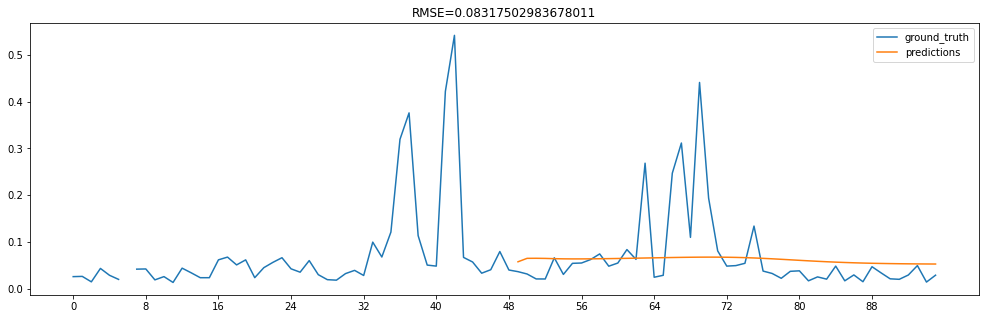

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(96,)
(96,)


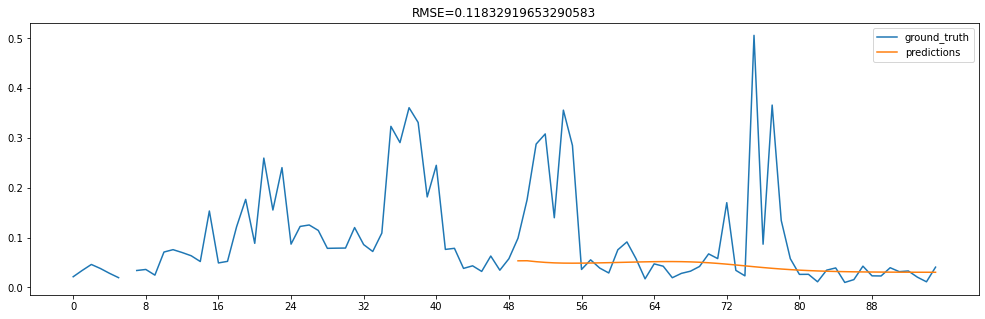

(96,)
(96,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


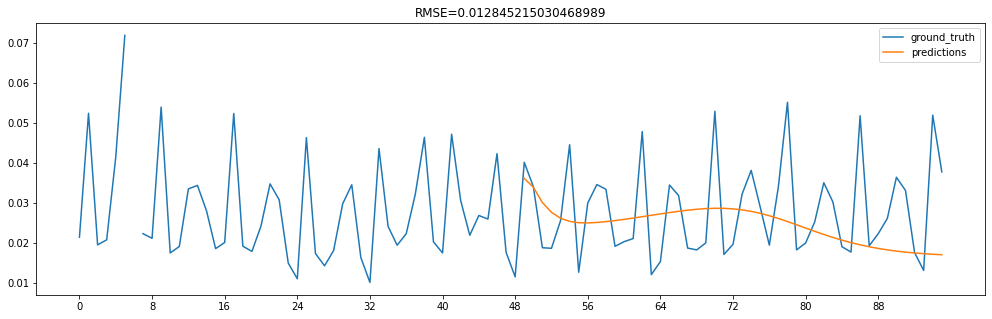

(96,)
(96,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


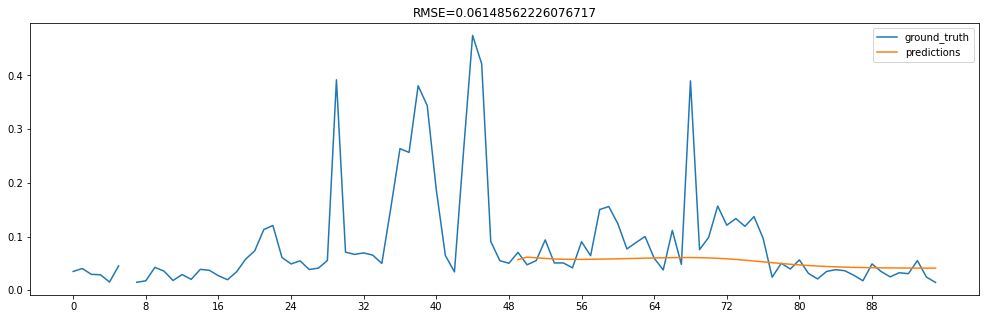

(96,)
(96,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


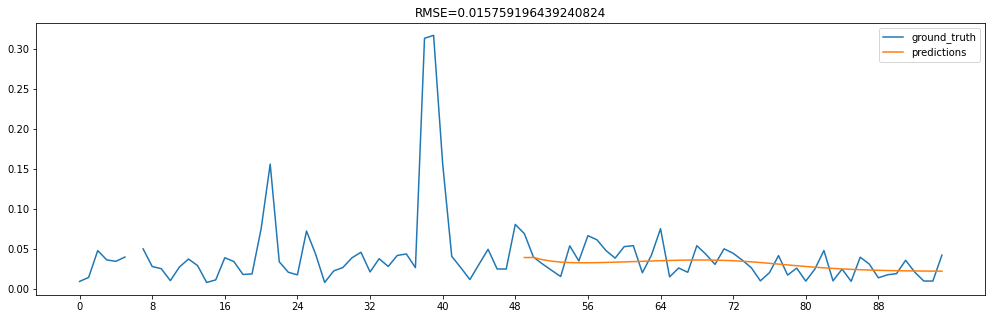

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(96,)
(96,)


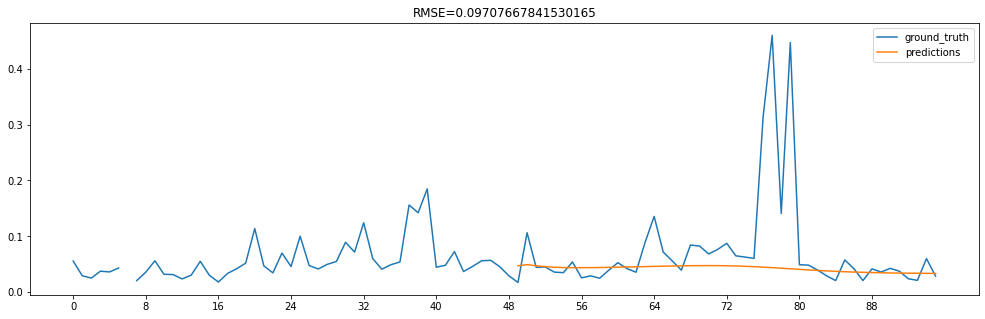

(96,)
(96,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


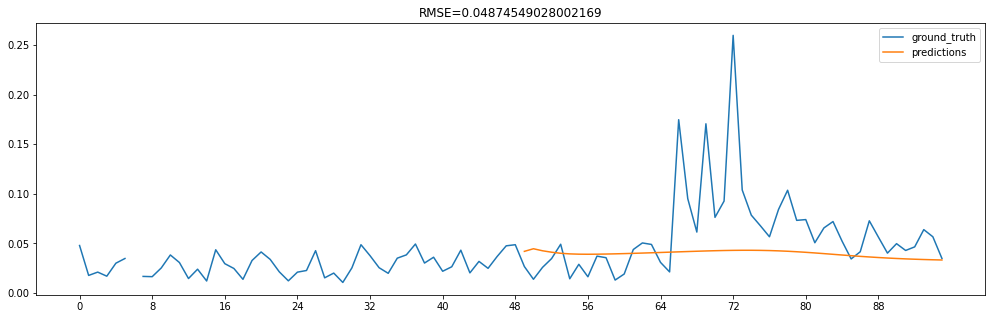

(96,)
(96,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


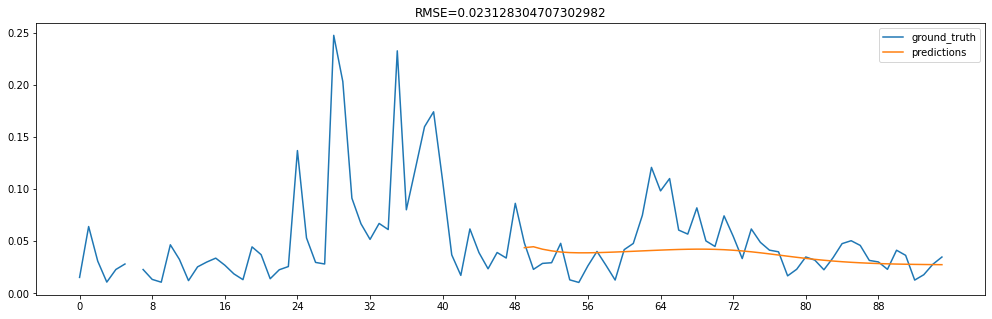

(96,)
(96,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


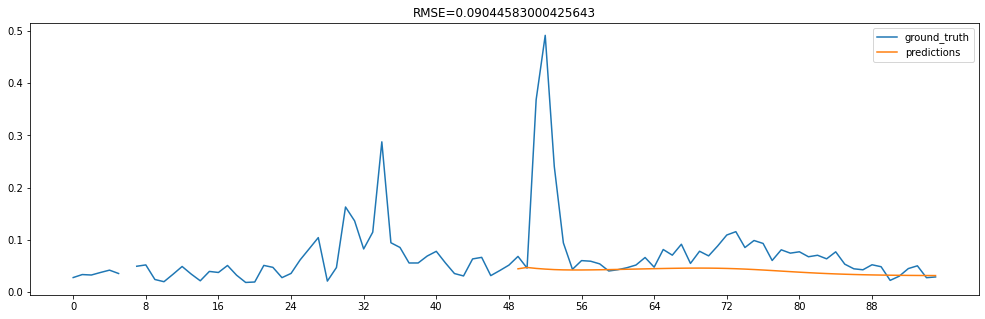

(96,)
(96,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


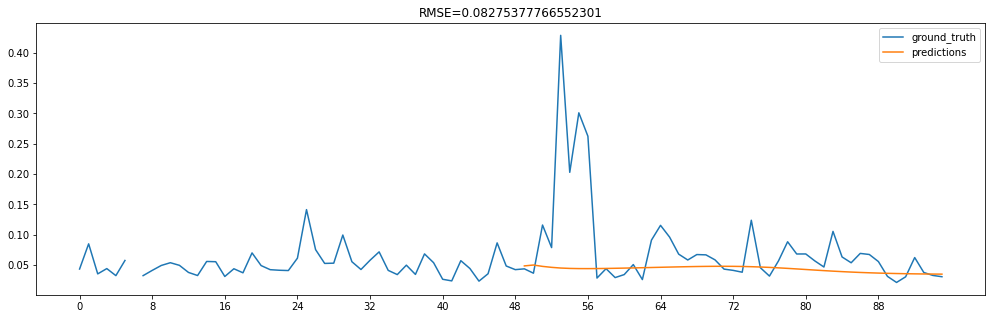

In [ ]:

model_bad.load_state_dict(torch.load("/content/drive/MyDrive/household_load_forecasting/Seq2Seq_experiments/models/model_bad.pt"))
model_bad.to(device)

test_models([model_bad], testloader, 2)

# Convolutional Seq2Seq

https://arxiv.org/abs/1705.03122

### Encoder

In [ ]:
class EncoderConv(nn.Module):
  def __init__(self, input_size, emb_size, hid_size, n_layers, kernel_size, dropout, device, max_length= 100):
    super(EncoderConv, self).__init__()

    assert kernel_size % 2 == 1, "Kernel size must be odd!"

    self.device = device
    # The scale variable is used by the authors to "ensure that the variance
    # throughout the network does not change dramatically".
    # The performance of the model seems to vary wildly
    # using different seeds if this is not used.
    self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device) # ~ 0.7
    self.tok_emb = nn.Linear(input_size,emb_size)
    self.pos_emb = nn.Embedding(max_length, emb_size)
    self.emb2hid = nn.Linear(emb_size, hid_size)
    self.hid2emb = nn.Linear(hid_size, emb_size)
    self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_size,
                                          out_channels = 2*hid_size,
                                          kernel_size = kernel_size,
                                          padding = (kernel_size -1) // 2
                                          )
                                for _ in range(n_layers)])
    self.dropout = nn.Dropout(dropout)


  def forward(self, src):
    batch_size = src.shape[0]
    src_len = src.shape[1]

    #pos = [batch_size, src_len] (of the longest seq in the batch)
    pos = torch.arange(0,src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

    tok_embedded = self.tok_emb(src)
    pos_embedded = self.pos_emb(pos)

    #element-wise summing of embeddings
    #embedded = [batch_size, src_len, emb_size]
    embedded = self.dropout(tok_embedded + pos_embedded)

    #conv_input = [batch_size, src_len, hidden_size]
    conv_input = self.emb2hid(embedded)

    conv_input = torch.einsum('ijk->ikj', conv_input)

    # conv likes dims = [batch_size, hidden_size, src_len]; n = batches, C_in = channels / hidden, L = length
    # https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
    for i, conv in enumerate(self.convs):

      conved = conv(self.dropout(conv_input))

      conved = F.glu(conved, dim = 1) # 1 (k) dim is now [hidden_size * 2]

      #residual

      #print(self.scale)
      conved = (conved + conv_input) * self.scale # 

      conv_input = conved


    conved = torch.einsum('ikj->ijk', conved)
    conved = self.hid2emb(conved)

    combined = (conved + embedded) * self.scale

    return conved, combined




                                                    



In [ ]:
enc_conv = EncoderConv(input_size=1, emb_size=1, hid_size=3, n_layers=2, kernel_size= 3, dropout = 0.5, device = device)

In [ ]:
conved, combined = enc_conv(src)


torch.Size([8, 48, 1])

### Decoder

In [ ]:
class DecoderConv(nn.Module):

  def __init__(self,
               input_size,
               emb_size,
               hid_size,
               output_size,
               n_layers,
               kernel_size,
               dropout,
               trg_pad_idx,
               device, 
               max_length=100):
    
    super(DecoderConv, self).__init__()
    
    self.device = device
    self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device) # ~ 0.7
    self.input_size = input_size
    self.hid_size = hid_size
    self.kernel_size = kernel_size
    self.trg_pad_idx = trg_pad_idx

    self.dropout = nn.Dropout(dropout)
    self.tok_emb = nn.Linear(input_size, emb_size)
    self.pos_emb = nn.Embedding(max_length, emb_size)
    self.emb2hid = nn.Linear(emb_size, hid_size)
    self.hid2emb = nn.Linear(hid_size, emb_size)
    self.att_hid2emb = nn.Linear(hid_size, emb_size)
    self.att_emb2hid = nn.Linear(emb_size, hid_size)
    self.fc_out = nn.Linear(emb_size, output_size)


    self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_size,
                                          out_channels = 2*hid_size,
                                          kernel_size = kernel_size
                                          )
                                for _ in range(n_layers)])



  def calc_att(self, embedded, conved, encoder_conved, encoder_combined):

    
    #encoder_conved = [N, src, emb]
    #encoder_combined = [N, src, emb]

    #conved; it comes out [N, hid_size, trg] from the conv1d layer 
    conved_permuted = torch.einsum('nht->nth', conved)
    # -> [N, trg, hid]


    conved_emb = self.att_hid2emb(conved_permuted)
    # [N, trg, emb]

    combined = (conved_emb + embedded) * self.scale

    encoder_conved_perm = torch.einsum('nse->nes', encoder_conved)

    energy = torch.einsum('nte,nes->nts', [combined, encoder_conved_perm])

    attention = F.softmax(energy, dim = 2) #over the source dimension, because later the encoders are weighted

    attended_encoding = torch.einsum('nts, nse->nte', attention, encoder_combined)

    attended_encoding = self.att_emb2hid(attended_encoding)
    #[N, trg, hid]

    attended_combined = (attended_encoding.permute(0,2,1) + conved) * self.scale


    return attention, attended_combined



  def forward(self, trg, encoder_conved, encoder_combined):

    batch_size = trg.shape[0]
    trg_len = trg.shape[1]

    pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

    tok_embedded = self.tok_emb(trg)
    pos_embedded = self.pos_emb(pos)

    embedded = self.dropout(tok_embedded + pos_embedded)

    conv_input = self.emb2hid(embedded)

    conv_input = torch.einsum('nth->nht', conv_input)

    for i, conv in enumerate(self.convs):

      conv_input = self.dropout(conv_input)

      # padding
      padding = torch.zeros(batch_size, self.hid_size, self.kernel_size -1).fill_(self.trg_pad_idx).to(self.device)

      padded_conv_input = torch.cat((padding, conv_input), dim = 2)
      # [N, h, t+k-1]

      conved = conv(padded_conv_input)
      # [N, 2*h, t]

      conved = F.glu(conved, dim = 1) #glu halves the dimension, this is why we setup the convs that way

      # [N, h , t]

      attention, conved = self.calc_att(embedded, conved, encoder_conved, encoder_combined)
      # att: [N, t, s]
      #conved: [N, h, t]

      conved = (conved + conv_input) * self.scale

      conv_input = conved #pass to the next layer


    conved = self.hid2emb(conved.permute(0,2,1))
    # [N, t, e]

    output = self.fc_out(self.dropout(conved))
    # [N, t, 1]

    return output, attention



In [ ]:

batch = iter(trainloader).next()
src, trg = batch
src = torch.tensor(src, dtype=torch.float32).to(device)
trg = torch.tensor(trg, dtype=torch.float32).to(device)



dec = DecoderConv(
               input_size = 1,
               emb_size = 1,
               hid_size = 3,
               output_size = 1,
               n_layers= 2,
               kernel_size=3,
               dropout=0.1,
               trg_pad_idx= 1,
               device=device, 
               max_length=100)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [ ]:
output, attn = dec(trg, conved, combined)

In [ ]:
class Seq2SeqConv(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len - 1] (<eos> token sliced off the end)
           
        #calculate z^u (encoder_conved) and (z^u + e) (encoder_combined)
        #encoder_conved is output from final encoder conv. block
        #encoder_combined is encoder_conved plus (elementwise) src embedding plus 
        #  positional embeddings 
        encoder_conved, encoder_combined = self.encoder(src)
            
        #encoder_conved = [batch size, src len, emb dim]
        #encoder_combined = [batch size, src len, emb dim]
        
        #calculate predictions of next words
        #output is a batch of predictions for each word in the trg sentence
        #attention a batch of attention scores across the src sentence for 
        #  each word in the trg sentence
        output, attention = self.decoder(trg, encoder_conved, encoder_combined)
        
        #output = [batch size, trg len - 1, output dim]
        #attention = [batch size, trg len - 1, src len]
        
        return output, attention

In [ ]:
TRG_PAD_IDX = 1e-10


enc_conv = EncoderConv(input_size=1,
                       emb_size=1,
                       hid_size=3,
                       n_layers=2, 
                       kernel_size= 3,
                       dropout = 0.5, 
                       device = device)

dec_conv = DecoderConv(
               input_size = 1,
               emb_size = 1,
               hid_size = 3,
               output_size = 1,
               n_layers= 2,
               kernel_size=3,
               dropout=0.1,
               trg_pad_idx= TRG_PAD_IDX,
               device=device, 
               max_length=100)

model_conv = Seq2SeqConv(enc_conv, dec_conv).to(device)

In [ ]:
print(f'The model has {count_parameters(model_conv):,} trainable parameters')

The model has 476 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def generate_square_subsequent_mask(dim1: int, dim2: int):
    """
    Generates an upper-triangular matrix of -inf, with zeros on diag.
    Modified from: 
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    Args:
        dim1: int, for both src and tgt masking, this must be target sequence
              length
        dim2: int, for src masking this must be encoder sequence length (i.e. 
              the length of the input sequence to the model), 
              and for tgt masking, this must be target sequence length 
    Return:
        A Tensor of shape [dim1, dim2]
    """
    return torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1)


In [ ]:
generate_square_subsequent_mask(3,3)

tensor([[0., -inf, -inf],
        [0., 0., -inf],
        [0., 0., 0.]])